In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.001

dv = 0.001

klin =0

nband = 200

ng =11

ng_adju = (/ -3 , -3 /) 

ng_refs = (/ 2 , 3 , 6 /) 

nref =3

nv = 1000

nv = 1000

option_compute_btable = 1

option_compute_ktable =0

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 10 , 500 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =294

vstar = 340

data w_diffuse
     &     /1.66 , 1.66 , 1.8 , 1.8,
     &     1.8 , 1.8 , 1.8 , 1.66,
     &     1.45 , 1.45 , 1.45/

data wgt
     &     /0.6 , 0.6 , 0.6 , 0.6,
     &     0.6 , 0.6 , 0.6 , 0.6,
     &     0.6 , 0.6 , 0.6/

atmosphere_profiles/mls75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

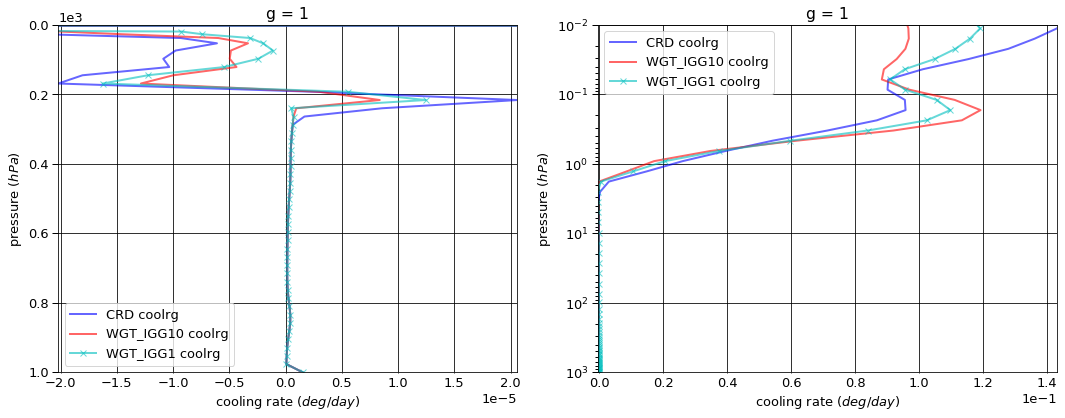

# Figure: cooling rate g-group 2

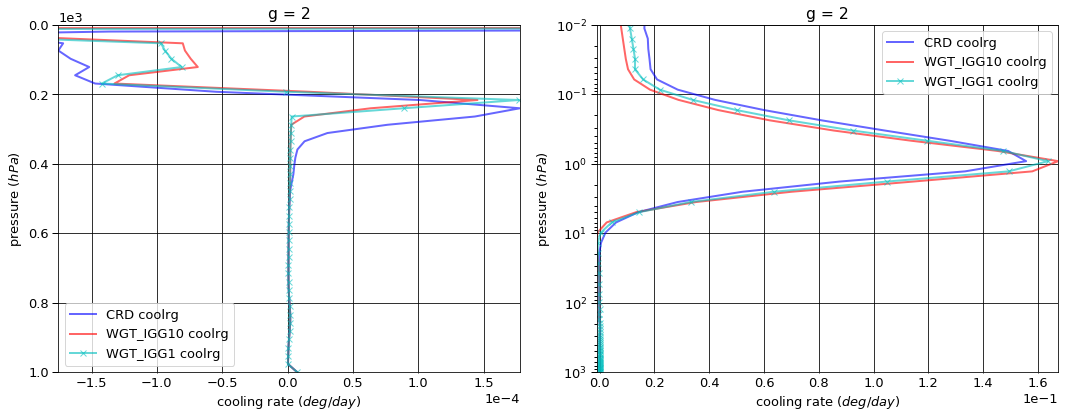

# Figure: cooling rate g-group 3

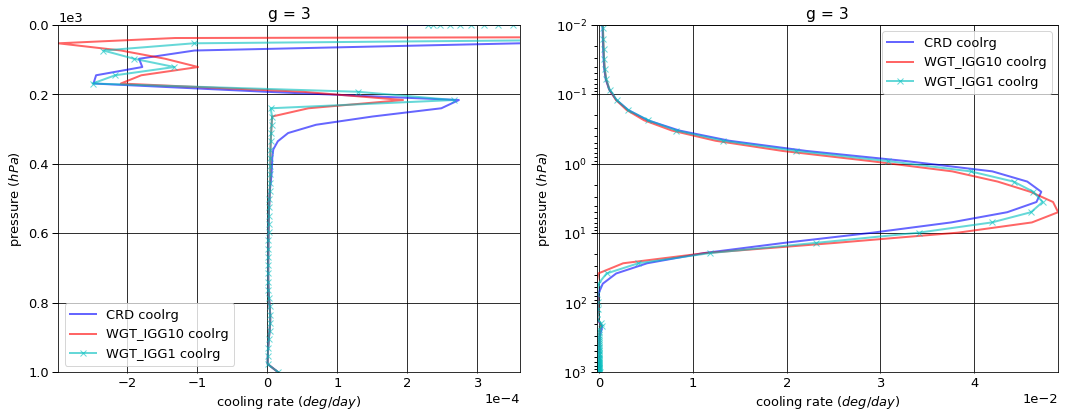

# Figure: cooling rate g-group 4

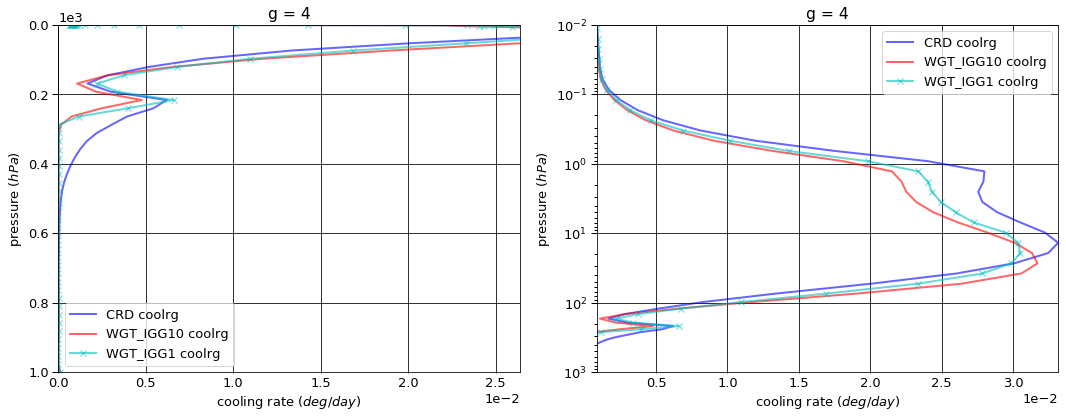

# Figure: cooling rate g-group 5

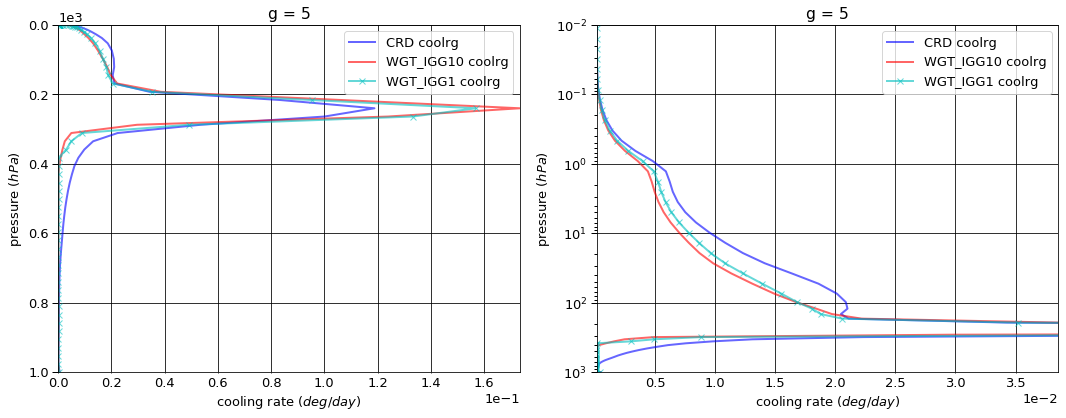

# Figure: cooling rate g-group 6

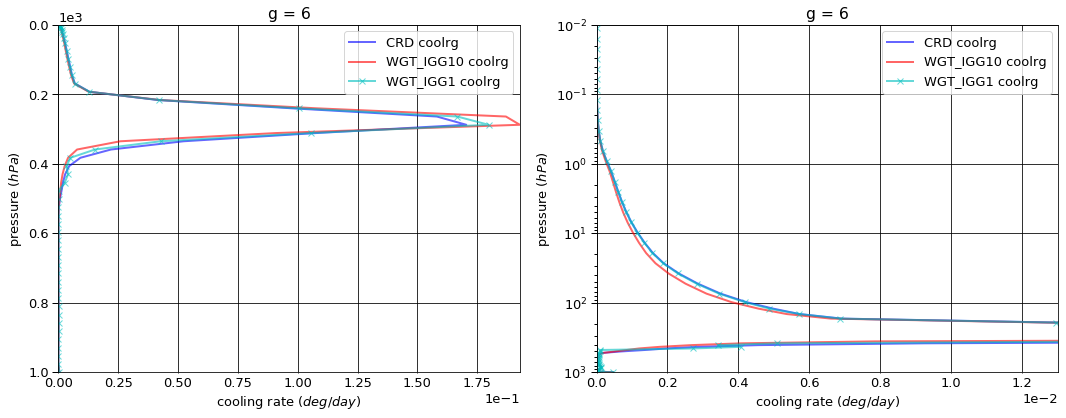

# Figure: cooling rate g-group 7

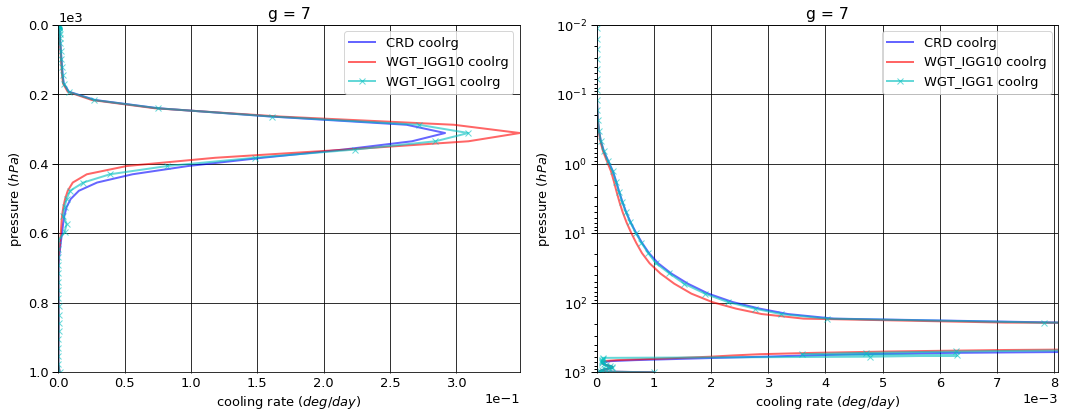

# Figure: cooling rate g-group 8

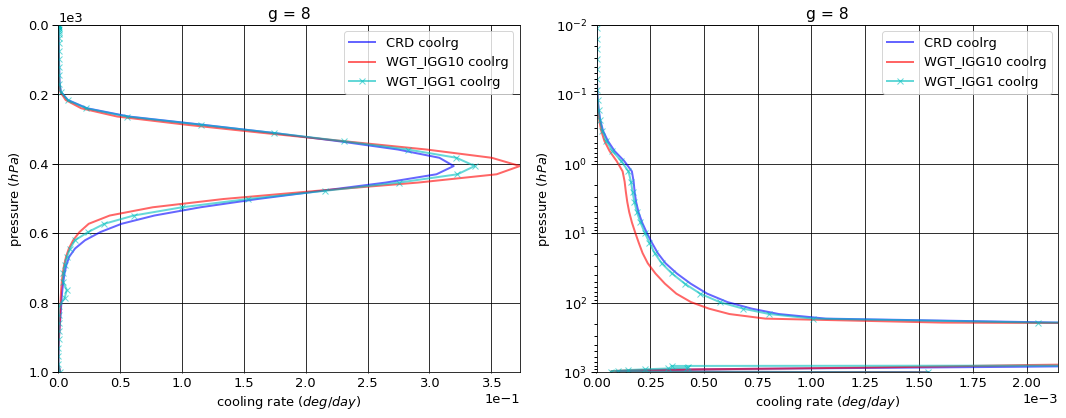

# Figure: cooling rate g-group 9

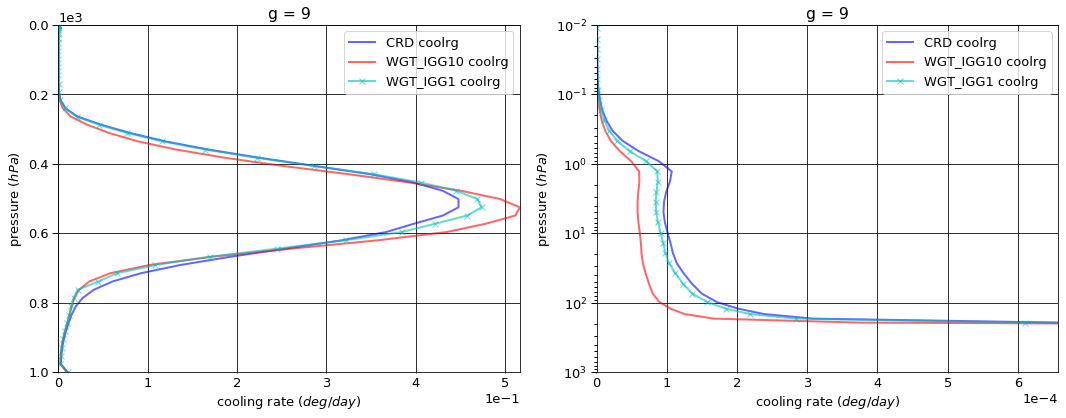

# Figure: cooling rate g-group 10

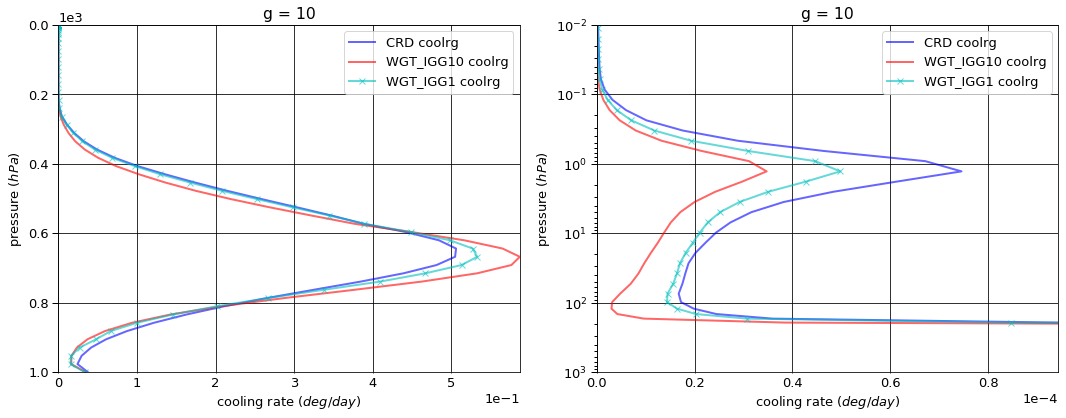

# Figure: cooling rate g-group 11

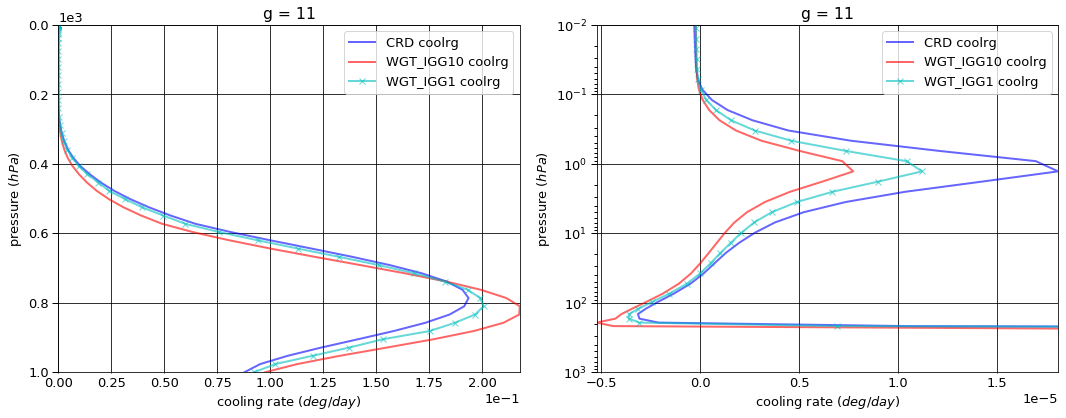

# Figure: cooling rate g-group total

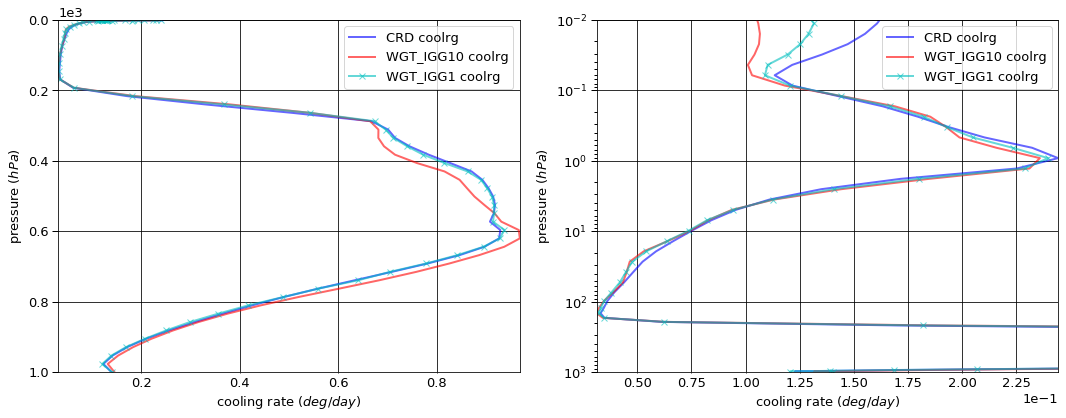

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.007788   0.000000  -0.007788
   1013.0   76     -0.012428   0.012424  -0.000004
2  0.0      1      -0.040888   0.000000  -0.040888
   1013.0   76     -0.057043   0.057022  -0.000021
3  0.0      1      -0.077290   0.000000  -0.077290
   1013.0   76     -0.127095   0.127051  -0.000044
4  0.0      1      -0.368540   0.000000  -0.368540
   1013.0   76     -0.728616   0.728359  -0.000257
5  0.0      1      -1.752079   0.000000  -1.752079
   1013.0   76     -3.354000   3.352636  -0.001363
6  0.0      1      -2.017650   0.000000  -2.017650
   1013.0   76     -3.620421   3.619156  -0.001266
7  0.0      1      -4.820873   0.000000  -4.820873
   1013.0   76     -7.955045   7.952270  -0.002775
8  0.0      1      -7.927499   0.000000  -7.927499
   1013.0   76    -11.890928  11.886663  -0.004265
9  0.0      1     -15.334051   0.000000 -15.334051
   1013.0   76    -20.820502  20.793619  -0.026883
10 0.0      1     -19.059195   0.000000 -19.059195
   1013.0   76    -23.612310  23.485346  -0.126964
11 0.0      1      -8.909516   0.000000  -8.909516
   1013.0   76    -10.137408   9.342523  -0.794885


WGT_IGG10


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.007558   0.000000  -0.007558
   1013.0   76     -0.012428   0.012424  -0.000004
2  0.0      1      -0.042776   0.000000  -0.042776
   1013.0   76     -0.057043   0.057022  -0.000021
3  0.0      1      -0.078812   0.000000  -0.078812
   1013.0   76     -0.127095   0.127051  -0.000044
4  0.0      1      -0.355260   0.000000  -0.355260
   1013.0   76     -0.728616   0.728360  -0.000256
5  0.0      1      -1.697888   0.000000  -1.697888
   1013.0   76     -3.354000   3.352821  -0.001179
6  0.0      1      -1.997427   0.000000  -1.997427
   1013.0   76     -3.620421   3.619156  -0.001266
7  0.0      1      -4.764470   0.000000  -4.764470
   1013.0   76     -7.955045   7.952270  -0.002775
8  0.0      1      -7.884832   0.000000  -7.884832
   1013.0   76    -11.890928  11.886663  -0.004265
9  0.0      1     -15.434617   0.000000 -15.434617
   1013.0   76    -20.820502  20.796125  -0.024377
10 0.0      1     -19.222341   0.000000 -19.222341
   1013.0   76    -23.612310  23.503498  -0.108812
11 0.0      1      -9.018272   0.000000  -9.018272
   1013.0   76    -10.137408   9.515917  -0.621491


WGT_IGG1


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.007600   0.000000  -0.007600
   1013.0   76     -0.012428   0.012424  -0.000004
2  0.0      1      -0.042268   0.000000  -0.042268
   1013.0   76     -0.057043   0.057022  -0.000021
3  0.0      1      -0.078160   0.000000  -0.078160
   1013.0   76     -0.127095   0.127051  -0.000044
4  0.0      1      -0.356171   0.000000  -0.356171
   1013.0   76     -0.728616   0.728360  -0.000256
5  0.0      1      -1.709969   0.000000  -1.709969
   1013.0   76     -3.354000   3.352821  -0.001179
6  0.0      1      -2.008983   0.000000  -2.008983
   1013.0   76     -3.620421   3.619156  -0.001266
7  0.0      1      -4.796965   0.000000  -4.796965
   1013.0   76     -7.955045   7.952270  -0.002775
8  0.0      1      -7.897527   0.000000  -7.897527
   1013.0   76    -11.890928  11.886663  -0.004265
9  0.0      1     -15.288899   0.000000 -15.288899
   1013.0   76    -20.820502  20.793327  -0.027175
10 0.0      1     -19.037732   0.000000 -19.037732
   1013.0   76    -23.612310  23.503649  -0.108660
11 0.0      1      -8.929338   0.000000  -8.929338
   1013.0   76    -10.137408   9.474567  -0.662841


WGT_IGG10 - CRD


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1      2.298069e-04  0.000000e+00  2.298069e-04
   1013.0   76     0.000000e+00  1.734723e-18  0.000000e+00
2  0.0      1     -1.888919e-03  0.000000e+00 -1.888919e-03
   1013.0   76    -6.938894e-18  0.000000e+00  3.388132e-21
3  0.0      1     -1.521372e-03  0.000000e+00 -1.521372e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
4  0.0      1      1.328076e-02  0.000000e+00  1.328076e-02
   1013.0   76     0.000000e+00  1.290000e-06  1.288590e-06
5  0.0      1      5.419070e-02  0.000000e+00  5.419070e-02
   1013.0   76     0.000000e+00  1.846000e-04  1.845295e-04
6  0.0      1      2.022290e-02  0.000000e+00  2.022290e-02
   1013.0   76     0.000000e+00  4.440892e-16  0.000000e+00
7  0.0      1      5.640240e-02  0.000000e+00  5.640240e-02
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
8  0.0      1      4.266760e-02  0.000000e+00  4.266760e-02
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
9  0.0      1     -1.005660e-01  0.000000e+00 -1.005660e-01
   1013.0   76    -3.552714e-15  2.506000e-03  2.506214e-03
10 0.0      1     -1.631460e-01  0.000000e+00 -1.631460e-01
   1013.0   76     0.000000e+00  1.815200e-02  1.815177e-02
11 0.0      1     -1.087559e-01  0.000000e+00 -1.087559e-01
   1013.0   76     0.000000e+00  1.733944e-01  1.733945e-01


WGT_IGG1 - CRD


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1      1.879421e-04  0.000000e+00  1.879421e-04
   1013.0   76     0.000000e+00  1.734723e-18  0.000000e+00
2  0.0      1     -1.380528e-03  0.000000e+00 -1.380528e-03
   1013.0   76    -6.938894e-18  0.000000e+00  3.388132e-21
3  0.0      1     -8.695170e-04  0.000000e+00 -8.695170e-04
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
4  0.0      1      1.236942e-02  0.000000e+00  1.236942e-02
   1013.0   76     0.000000e+00  1.290000e-06  1.288590e-06
5  0.0      1      4.211000e-02  0.000000e+00  4.211000e-02
   1013.0   76     0.000000e+00  1.846000e-04  1.845295e-04
6  0.0      1      8.667200e-03  0.000000e+00  8.667200e-03
   1013.0   76     0.000000e+00  4.440892e-16  0.000000e+00
7  0.0      1      2.390820e-02  0.000000e+00  2.390820e-02
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
8  0.0      1      2.997210e-02  0.000000e+00  2.997210e-02
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
9  0.0      1      4.515200e-02  0.000000e+00  4.515200e-02
   1013.0   76    -3.552714e-15 -2.920000e-04 -2.921410e-04
10 0.0      1      2.146300e-02  0.000000e+00  2.146300e-02
   1013.0   76     0.000000e+00  1.830300e-02  1.830366e-02
11 0.0      1     -1.982150e-02  0.000000e+00 -1.982150e-02
   1013.0   76     0.000000e+00  1.320445e-01  1.320445e-01

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1      1.427961e-01
   1001.112500 75     1.510265e-06
2  0.000312    1      1.096711e-02
   1001.112500 75     7.479244e-06
3  0.000312    1      2.005064e-04
   1001.112500 75     1.589404e-05
4  0.000312    1      6.251428e-04
   1001.112500 75     9.281350e-05
5  0.000312    1      8.915757e-05
   1001.112500 75     4.890355e-04
6  0.000312    1      3.190686e-07
   1001.112500 75     4.571754e-04
7  0.000312    1      5.044384e-07
   1001.112500 75     1.002471e-03
8  0.000312    1      1.041047e-06
   1001.112500 75     1.543834e-03
9  0.000312    1      7.489964e-07
   1001.112500 75     1.044827e-02
10 0.000312    1     -1.101388e-07
   1001.112500 75     3.776908e-02
11 0.000312    1     -4.095740e-07
   1001.112500 75     8.776458e-02


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      7.937673e-02
   1001.112500 75     1.510265e-06
2  0.000312    1      3.677253e-03
   1001.112500 75     7.479244e-06
3  0.000312    1      2.351472e-04
   1001.112500 75     1.589404e-05
4  0.000312    1      6.442237e-04
   1001.112500 75     9.233084e-05
5  0.000312    1      9.822953e-05
   1001.112500 75     4.258362e-04
6  0.000312    1      2.824948e-07
   1001.112500 75     4.571754e-04
7  0.000312    1      4.282227e-07
   1001.112500 75     1.002471e-03
8  0.000312    1      7.323892e-07
   1001.112500 75     1.540595e-03
9  0.000312    1      2.445340e-07
   1001.112500 75     9.618578e-03
10 0.000312    1     -2.121600e-07
   1001.112500 75     3.496085e-02
11 0.000312    1     -2.559658e-07
   1001.112500 75     9.747083e-02


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1      1.060020e-01
   1001.112500 75     1.510265e-06
2  0.000312    1      6.041753e-03
   1001.112500 75     7.479244e-06
3  0.000312    1      2.288965e-04
   1001.112500 75     1.589404e-05
4  0.000312    1      6.691802e-04
   1001.112500 75     9.233084e-05
5  0.000312    1      1.102852e-04
   1001.112500 75     4.258362e-04
6  0.000312    1      3.249826e-07
   1001.112500 75     4.571754e-04
7  0.000312    1      5.008000e-07
   1001.112500 75     1.002471e-03
8  0.000312    1      9.955959e-07
   1001.112500 75     1.540595e-03
9  0.000312    1      5.540321e-07
   1001.112500 75     1.059979e-02
10 0.000312    1     -1.024535e-07
   1001.112500 75     3.406157e-02
11 0.000312    1     -2.757792e-07
   1001.112500 75     9.227897e-02


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -6.341937e-02
   1001.112500 75     0.000000e+00
2  0.000312    1     -7.289857e-03
   1001.112500 75     0.000000e+00
3  0.000312    1      3.464082e-05
   1001.112500 75     0.000000e+00
4  0.000312    1      1.908096e-05
   1001.112500 75    -4.826550e-07
5  0.000312    1      9.071958e-06
   1001.112500 75    -6.319928e-05
6  0.000312    1     -3.657383e-08
   1001.112500 75     0.000000e+00
7  0.000312    1     -7.621574e-08
   1001.112500 75     0.000000e+00
8  0.000312    1     -3.086575e-07
   1001.112500 75    -3.238800e-06
9  0.000312    1     -5.044624e-07
   1001.112500 75    -8.296881e-04
10 0.000312    1     -1.020213e-07
   1001.112500 75    -2.808236e-03
11 0.000312    1      1.536083e-07
   1001.112500 75     9.706245e-03


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -3.679407e-02
   1001.112500 75     0.000000e+00
2  0.000312    1     -4.925357e-03
   1001.112500 75     0.000000e+00
3  0.000312    1      2.839009e-05
   1001.112500 75     0.000000e+00
4  0.000312    1      4.403742e-05
   1001.112500 75    -4.826550e-07
5  0.000312    1      2.112768e-05
   1001.112500 75    -6.319928e-05
6  0.000312    1      5.914010e-09
   1001.112500 75     0.000000e+00
7  0.000312    1     -3.638470e-09
   1001.112500 75     0.000000e+00
8  0.000312    1     -4.545084e-08
   1001.112500 75    -3.238800e-06
9  0.000312    1     -1.949643e-07
   1001.112500 75     1.515230e-04
10 0.000312    1      7.685220e-09
   1001.112500 75    -3.707508e-03
11 0.000312    1      1.337948e-07
   1001.112500 75     4.514383e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-60.315369,0.000000,-60.315369
1013.0,76,-82.315796,81.357068,-0.958727



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-60.504253,0.000000,-60.504253
1013.0,76,-82.315796,81.551307,-0.764488



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-60.153611,0.00000,-60.153611
1013.0,76,-82.315796,81.50731,-0.808485



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.188884,0.000000,-0.188884
1013.0,76,0.000000,0.194238,0.194238



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.161758,0.000000,0.161758
1013.0,76,0.000000,0.150241,0.150242


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.154680
1001.112500,75,0.139592



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.084033
1001.112500,75,0.145594



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.113054
1001.112500,75,0.140484



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.070647
1001.112500,75,0.006001



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.041626
1001.112500,75,0.000891


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000165,0.000158
2,0.000710,0.000702
3,0.001650,0.001595
4,0.009355,0.009096
5,0.043000,0.041841
6,0.046540,0.045262
7,0.102785,0.099548
8,0.149970,0.147090
9,0.254670,0.254476


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,7.307308e-18
2,3.831004e-19
3,1.728743e-19
4,9.339312e-21
5,5.045443e-22
6,5.814950e-21
7,1.353900e-21
8,3.152298e-22
9,7.339523e-23


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,7.307308e-18,NaN,0.000165,0.000158,0.000165,0.000158,1.0
2,3.831004e-19,0.052427,0.000710,0.000702,0.000875,0.000860,1.0
3,1.728743e-19,0.451251,0.001650,0.001595,0.002525,0.002455,10.0
4,9.339312e-21,0.054024,0.009355,0.009096,0.011880,0.011552,10.0
5,5.045443e-22,0.054024,0.043000,0.041841,0.054880,0.053392,10.0
6,5.814950e-21,11.525153,0.046540,0.045262,0.101420,0.098655,500.0
7,1.353900e-21,0.232831,0.102785,0.099548,0.204205,0.198202,500.0
8,3.152298e-22,0.232831,0.149970,0.147090,0.354175,0.345293,500.0
9,7.339523e-23,0.232831,0.254670,0.254476,0.608845,0.599768,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
